In [1]:
import numpy as np 
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.cluster import KMeans
%matplotlib qt
import pickle 

## Pipeline

In [2]:
def tlvParsing(data, tlvHeaderLengthInBytes, pointLengthInBytes, targetLengthInBytes):
    
    data = np.frombuffer(data, dtype = 'uint8')
    
    targetDict = dict()
    pointCloud = np.array([])
    index = 0
    #tlv header parsing
    tlvType = data[index:index+4].view(dtype=np.uint32)
    tlvLength = data[index+4:index+8].view(dtype=np.uint32)
    
    index += tlvHeaderLengthInBytes
    pointCloudDataLength = tlvLength - tlvHeaderLengthInBytes
    if tlvType.size > 0 and tlvType == 6: #point cloud TLV
        numberOfPoints = pointCloudDataLength/pointLengthInBytes
        if numberOfPoints > 0:
            p = data[index:index+pointCloudDataLength[0]].view(dtype=np.single)
            #form the appropriate array 
            #each point is 16 bytes - 4 bytes for each property - range, azimuth, doppler, snr
            pointCloud = np.reshape(p,(4, int(numberOfPoints)),order="F")
    
    #increment the index so it is possible to read the target list
    index += pointCloudDataLength
    #tlv header parsing
    tlvType = data[index[0]:index[0]+4].view(dtype=np.uint32)
    tlvLength = data[index[0]+4:index[0]+8].view(dtype=np.uint32)
    index += tlvHeaderLengthInBytes
    targetListDataLength = tlvLength - tlvHeaderLengthInBytes
    if tlvType.size > 0 and tlvType == 7: #target List TLV
        
        numberOfTargets = targetListDataLength/targetLengthInBytes
        TID = np.zeros((1, int(numberOfTargets[0])), dtype = np.uint32) #tracking IDs
        kinematicData = np.zeros((6, int(numberOfTargets[0])), dtype = np.single)
        errorCovariance = np.zeros((9, int(numberOfTargets[0])), dtype = np.single)
        gatingGain = np.zeros((1, int(numberOfTargets[0])), dtype = np.single)
        
        #increment the index so it is possible to read the target list
        targetIndex = 0
        while targetIndex != int(numberOfTargets[0]):
            TID[0][targetIndex] = data[index[0]:index[0]+4].view(dtype=np.uint32)
            kinematicData[:,targetIndex] = data[index[0]+4:index[0]+28].view(dtype=np.single)
            errorCovariance[:,targetIndex] = data[index[0]+28:index[0]+64].view(dtype=np.single)
            gatingGain[:,targetIndex] = data[index[0]+64:index[0]+68].view(dtype=np.single)
            index += targetLengthInBytes
            targetIndex += 1
            
        targetDict['TID'] = TID
        targetDict['kinematicData'] = kinematicData
        targetDict['errorCovariance'] = errorCovariance
        targetDict['gatingGain'] = gatingGain
    
    return pointCloud, targetDict

def parsePointCloud(pointCloud): #remove points that are not within the boundary
    
    effectivePointCloud = np.array([])
    posX = np.array([])
    posY = np.array([])
    SNR = np.array([])
    
    for index in range(0, len(pointCloud[0,:])):
        if (pointCloud[0,index] > 1 and pointCloud[0,index] < 6) \
        and (pointCloud[1, index] > -50*np.pi/180 \
            and pointCloud[1, index] < 50*np.pi/180):

            #concatenate columns to the new point cloud
            if len(effectivePointCloud) == 0:
                effectivePointCloud = np.reshape(pointCloud[:, index], (4,1), order="F")
            else:
                point = np.reshape(pointCloud[:, index], (4,1),order="F")
                effectivePointCloud = np.hstack((effectivePointCloud, point))

    if len(effectivePointCloud) != 0:
        posX = np.multiply(effectivePointCloud[0,:], np.sin(effectivePointCloud[1,:]))
        posY = np.multiply(effectivePointCloud[0,:], np.cos(effectivePointCloud[1,:]))
        SNR  = effectivePointCloud[3,:]
    
    return posX,posY,SNR

def iterativeDfs(vertexID, edgeMatrix, startNode):
    
    visited = np.array([], dtype=np.int)
    dfsStack = np.array([startNode])

    while dfsStack.size > 0:
        vertex, dfsStack = dfsStack[-1], dfsStack[:-1] #equivalent to stack pop function
        if vertex not in visited:
            #find unvisited nodes
            unvisitedNodes = vertexID[np.logical_not(np.isnan(edgeMatrix[int(vertex), :]))]
            visited = np.append(visited, vertex)
            #add unvisited nodes to the stack
            dfsStack = np.append(dfsStack, unvisitedNodes[np.logical_not(np.isin(unvisitedNodes,visited))])
    
    return visited

def TreeClustering(posX, posY, SNR, weightThreshold, minClusterSize):
    
    vertexID = np.arange(len(posX))
    vertexList = np.arange(len(posX))

    associatedPoints = np.array([])

    if len(posX) >= minClusterSize:
        edgeMatrix = np.zeros((len(posX), len(posY)))

        #create distance matrix
        #x1 - x0
        xDifference = np.subtract(np.repeat(posX, repeats=len(posX)).reshape(len(posX), len(posX)), 
                                  np.transpose(np.repeat(posX, repeats=len(posX)).reshape(len(posX), len(posX))))
        #y1 - y0
        yDifference = np.subtract(np.repeat(posY, repeats=len(posY)).reshape(len(posY), len(posY)), 
                                  np.transpose(np.repeat(posY, repeats=len(posY)).reshape(len(posY), len(posY))))
        #euclidean distance calculation
        edgeMatrix = np.sqrt(np.add(np.square(xDifference), np.square(yDifference)))

        #weight based reduction of graph/remove edges by replacing edge weight by np.NaN
        weightMask = np.logical_or(np.greater(edgeMatrix,weightThreshold), np.equal(edgeMatrix, 0))
        edgeMatrix[weightMask] = np.NaN

        #perform iterative dfs
        associatedPoints = np.array([])
        
        centroidNumber = 0
        while vertexID.size > 0:
            startNode = vertexID[0]
            visited = iterativeDfs(vertexList, edgeMatrix, startNode)
            #remove visited nodes (ie only slice off all unvisited nodes)
            vertexID = vertexID[np.logical_not(np.isin(vertexID, visited))]
#             #visited is a component, extract cluster from it if possible
            if visited.size >= minClusterSize:
                cluster =  np.array([posX[visited], posY[visited],SNR[visited],
                                     np.repeat(centroidNumber, repeats=len(visited))])
                if associatedPoints.size == 0:
                    associatedPoints = cluster
                else:
                    associatedPoints = np.hstack((associatedPoints, cluster))
                centroidNumber += 1

    return associatedPoints

def predict(x, P, A, Q): #predict function
    xpred = np.matmul(A,x)
    Ppred = np.matmul(A,P)
    Ppred = np.matmul(Ppred,np.transpose(A)) + Q
    return(xpred, Ppred)

def innovation(xpred, Ppred, z, H, R): #innovation function
    nu = z - np.matmul(H,xpred)
    S = np.matmul(H,Ppred)
    S = R + np.matmul(S, np.transpose(H))
    return(nu, S)

def innovation_update(xpred, Ppred, nu, S, H):
    K = np.matmul(Ppred, np.transpose(H))
    K = np.matmul(K,np.linalg.inv(S)) #check inverse function
    xnew = xpred + np.matmul(K,nu)
    Pnew = np.matmul(K,S)
    Pnew = Ppred - np.matmul(Pnew,np.transpose(K)) 
    return(xnew, Pnew)

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def data_associate(centroidPred, rthetacentroid):
    minDist = np.array([])
    rthetacentroidCurrent = rthetacentroid
    centpredCol = np.size(centroidPred,1)
    rthetaCol = np.size(rthetacentroid,1)

    for i in list(range(0,centpredCol)):
        r1 = centroidPred[0][i]
        r2 = rthetacentroid[0]
        theta1 = centroidPred[2][i]
        theta2 = rthetacentroid[1]
        temp = np.sqrt(np.multiply(r1,r1) + np.multiply(r2,r2) - np.multiply(np.multiply(np.multiply(2,r1),r2),np.cos(theta2-theta1)))
        if(i==0):
            minDist = temp
        else:
            minDist = np.vstack((minDist,temp))

    currentFrame = np.empty((2,max(centpredCol,rthetaCol)))
    currentFrame[:] = np.nan

    minDist = np.reshape(minDist, (centpredCol,rthetaCol))
    minDistOrg = minDist

    for i in list(range(0,min(centpredCol,rthetaCol))):
        if((np.ndim(minDist)) == 1):
            minDist = np.reshape(minDist,(rthetaCol,1))
            minDistOrg = np.reshape(minDistOrg,(rthetaCol,1))
        val = np.min(minDist)
        resultOrg = np.argwhere(minDistOrg == val)
        result = np.argwhere(minDist == val)
        minRowOrg = resultOrg[0][0]
        minColOrg = resultOrg[0][1]
        minRow = result[0][0]
        minCol = result[0][1]
        currentFrame[:,minRowOrg] = rthetacentroid[:,minColOrg]
        minDist = np.delete(minDist,minRow,0)
        minDist = np.delete(minDist,minCol,1)
        rthetacentroidCurrent = np.delete(rthetacentroidCurrent,minCol,1)

    index = 0
    if (rthetacentroidCurrent.size != 0): #check indexing
        for i in list(range(centpredCol,rthetaCol)):
            currentFrame[:,i] = rthetacentroidCurrent[:,index]
            index += 1 

    return(currentFrame)

def LiveRKF(currentrawxycentroidData, centroidX, centroidP, Q, R, isFirst):
    
    
    #initialise matrices 
    delT = 0.0500
    A = np.array([[1,delT,0,0], 
                  [0,1  ,0,0], 
                  [0,0,1,delT], 
                  [0,0,0,1]])
    H = np.array([[1,0,0,0],
                  [0,0,1,0]])
    P = np.identity(4)

    xytransposecentroidData = currentrawxycentroidData
    rthetacentroidData=xytransposecentroidData
    if (xytransposecentroidData.size != 0): 
        [rthetacentroidData[0,:],rthetacentroidData[1,:]] = cart2pol(xytransposecentroidData[0,:],xytransposecentroidData[1,:])
    if(isFirst):
        centroidX[[0,2],0] = rthetacentroidData[[0,1],0]
        isFirst = 0
    if((rthetacentroidData.size != 0)):
        currentFrame = data_associate(centroidX, rthetacentroidData)
        addittionalCentroids = (np.size(rthetacentroidData,1)-np.size(centroidX,1))
        if(addittionalCentroids>0):
            truncateCurrentFrame = currentFrame[:,np.size(centroidX,1):np.size(currentFrame,1)]
            zeroTemplate = np.zeros((4,np.size(truncateCurrentFrame,1)),dtype=truncateCurrentFrame.dtype)
            zeroTemplate[[0,2],:] = truncateCurrentFrame[[0,1],:]
            centroidX = np.hstack((centroidX,zeroTemplate))
            for newFrameIndex in list((range(0, addittionalCentroids))):
                centroidP.extend([P])
        for currentFrameIndex in list((range(0,np.size(currentFrame,1)))):
            if(not(np.isnan(currentFrame[0,currentFrameIndex]))):
                [xpred, Ppred] = predict(centroidX[:,currentFrameIndex], centroidP[currentFrameIndex], A, Q)
                [nu, S] = innovation(xpred, Ppred, currentFrame[:, currentFrameIndex], H, R)
                [centroidX[:,currentFrameIndex],  centroidP[currentFrameIndex]] = innovation_update(xpred, Ppred, nu, S, H)
            else:
                [centroidX[:,currentFrameIndex], centroidP[currentFrameIndex]] = predict(centroidX[:,currentFrameIndex], centroidP[currentFrameIndex], A, Q)                   
    else:
        for noFrameIndex in list((range(0,np.size(centroidX,1)))):
            [centroidX[:,noFrameIndex], centroidP[noFrameIndex]] = predict(centroidX[:,noFrameIndex], centroidP[noFrameIndex], A, Q)
    #centroidX is 4xN array that contains that centroid information for that frame
    return centroidX, centroidP,isFirst


In [173]:
#SETUP TO GET AVERAGE SNR 
parsingMatFile = 'C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Data\\Experiment 3\\OnePersonThanu.mat'
tlvData = (loadmat(parsingMatFile))['tlvStream'][0]

#RKF 
centroidX =np.zeros((4,1))
centroidP = []
P = np.identity(4)
centroidP.extend([P])
Q = np.multiply(0.5,np.identity(4))
R = np.multiply(5,np.array([[1],[1]]))
#tree based
weightThresholdIntial = 0.2 #minimum distance between points
minClusterSizeInitial = 10
weightThresholdFinal = 0.8 #minimum distance between points
minClusterSizeFinal = 8 
    
#zone snr
snrFirstZone = 10
snrMiddleZone = 15
snrLastZone = 5

tlvHeaderLengthInBytes = 8
pointLengthInBytes = 16
targetLengthInBytes = 68

tiPosX = np.array([])
tiPosY = np.array([])

tiOutput = np.array([])
kalmanOutput = np.array([])
clusteringOutput = np.array([])
snrFilteredClusters = np.array([])
groundTruth = 0
xPositions = np.array([])

groundTruthDataCollection = False
locationDataNeeded = False
xGroup16 = np.array([])
yGroup16 = np.array([])
xLocationTI = np.array([])
yLocationTI = np.array([])

measuredX = np.array([])
measuredY = np.array([])
predictedX = np.array([])
predictedY = np.array([])
isFirst = 1
snrRange = np.array([])

for index in range(0, len(tlvData)):
    tlvStream = tlvData[index]

    #parsing
    pointCloud, targetDict = tlvParsing(tlvStream, tlvHeaderLengthInBytes, pointLengthInBytes, targetLengthInBytes)

    if pointCloud.size > 0:
        posX,posY,SNR = parsePointCloud(pointCloud) #dictionary that contains the point cloud data
        
        #initial noise reduction
        clusters = TreeClustering(posX, posY, SNR,weightThresholdIntial, minClusterSizeInitial)

        if clusters.size > 0:
#             row 1 - x
#             row 2 - y
#             row 3 - SNR
#             row 4 - cluster number

#             snr zone snr test
#             4.5 to the end -> last zone
#             3-4.5m -> middle zone
#             1-3m -> first zone
            snrMask_LastZone = np.logical_and(np.greater(clusters[1,:], 4.5), np.greater(clusters[2,:], snrLastZone)) #zone 4.5m and greater
            snrMask_MiddleZone = np.logical_and(np.logical_and(np.greater(clusters[1,:], 3), np.less_equal(clusters[1,:], 4.5)), 
                                                np.greater(clusters[2,:], snrMiddleZone)) #zone 3-4.5m with SNR > 20
            snrMask_FirstZone = np.logical_and(np.less_equal(clusters[1,:], 3), np.greater(clusters[2,:], snrFirstZone))
            overallSnrMask = np.logical_or(np.logical_or(snrMask_FirstZone,snrMask_MiddleZone), snrMask_LastZone)

            snrFilteredClusters = clusters[:,overallSnrMask]
            
            if snrFilteredClusters.size > 0:
                dbClusters = TreeClustering(snrFilteredClusters[0,:], snrFilteredClusters[1,:], 
                                                snrFilteredClusters[2,:], 
                                                weightThresholdFinal, minClusterSizeFinal)
                if dbClusters.size > 0:
                    #row 1 - x
                    #row 2 - y
                    #row 3 - cluster number
                    k = int(max(dbClusters[3,:])) + 1 
                    points = np.transpose(np.array([dbClusters[0,:], dbClusters[1,:]]))

                    #kmeans 
                    centroidClusterer = KMeans(n_clusters= k).fit(points)

                    centroidData = np.array([centroidClusterer.cluster_centers_[:,0], centroidClusterer.cluster_centers_[:,1]])
                    #tracking
                    centroidX, centroidP,isFirst = LiveRKF(centroidData, centroidX, centroidP, Q, R, isFirst)
                    #calculate x and y positions
                    xPositions = np.multiply(centroidX[0,:], np.cos(centroidX[2,:]))
                    yPositions = np.multiply(centroidX[0,:], np.sin(centroidX[2,:]))
                    mask = np.logical_and((np.logical_and(xPositions<3,xPositions>-4)), np.logical_and(yPositions<5.5,yPositions>0.5))
                    xPositions = xPositions[mask]
                    yPositions= yPositions[mask]
                    #keep centroids that are inside the constraints 
                    centroidX = centroidX[:,mask]
    
                    #TI and GP16 
                    if len(targetDict) != 0:
                        #kinematic data object structure
                        #row 0 - posX
                        #row 1 - posY 
                        #row 2 - velX
                        #row 3 - velY
                        #row 4 - accX
                        #row 5 - accY
                        tiPosX = targetDict['kinematicData'][0,:]
                        tiPosY = targetDict['kinematicData'][1,:]
                        #enforce limits on TI 
                        mask = np.logical_and(np.logical_and(tiPosX<3,tiPosX>-4),np.logical_and(tiPosY<5.5,tiPosY>0.5))
                        xTi = tiPosX[mask]
                        yTi = tiPosY[mask]

                        #save x,y TI locations
                        if xLocationTI.size == 0:
                            xLocationTI = xTi
                        else:
                            xLocationTI = np.append(xLocationTI,xTi)

                        if yLocationTI.size == 0:
                            yLocationTI = yTi
                        else:
                            yLocationTI = np.append(yLocationTI, yTi)
                            
                        #save x,y GP16 locations (filtered results)
                        if xGroup16.size == 0:
                            xGroup16 = xPositions
                        else:
                            xGroup16 = np.append(xGroup16,xPositions)

                        if yGroup16.size == 0:
                            yGroup16 = yPositions
                        else:
                            yGroup16 = np.append(yGroup16, yPositions)
                            
                        #save measured data
                        if measuredX.size == 0:
                            measuredX = centroidClusterer.cluster_centers_[:,0]
                        else:
                            measuredX = np.append(measuredX, centroidClusterer.cluster_centers_[:,0])
                        if measuredY.size == 0:
                            measuredY = centroidClusterer.cluster_centers_[:,1]
                        else:
                            measuredY = np.append(measuredY, centroidClusterer.cluster_centers_[:,1])
                            
                        #save SNR information (SNR vs Range)
                        rangeInfo = np.sqrt(np.add(dbClusters[0,:]**2, dbClusters[1,:]**2))
                        mask = np.equal(np.max(dbClusters[2,:]),dbClusters[2,:])
                        snrInfo = np.array([rangeInfo[mask][0],np.max(dbClusters[2,:])])
                        if snrRange.size == 0:
                            snrRange = snrInfo
                        else:
                            snrRange = np.vstack((snrRange, snrInfo))
   

In [174]:
#save SNR info as pickle
snrDf = pd.DataFrame(snrRange, columns=['Range', 'SNR'])
#save snrRange data to list
snrRangeList.append(snrDf)

In [177]:
#write SNRRangeList to pickle 
#each element is the datasets for 1 person to 5 people (snr vs range)
pickle.dump(snrRangeList, open("snrRangeList.p", "wb"))

## Q, R CSV

In [132]:
qrDf= pd.DataFrame(np.transpose(np.array([xGroup16,yGroup16,measuredX,measuredY,xLocationTI,yLocationTI])),
             columns=['x16','y16','measuredX','measuredY','xTI','yTI'])
#baseline QR with identity 
qrDf.to_csv("C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\QR\\modifedQR1.csv")

## Average SNR vs Range

In [41]:
snrRangeList = pickle.load(open("snrRangeList.p",'rb'))
overallDataset = np.array([])
numberOfPeople = 1
for dataset in snrRangeList:
    if overallDataset.size == 0:
        overallDataset = np.hstack((dataset.values, np.expand_dims(np.repeat(numberOfPeople, repeats=dataset.shape[0]), axis=1)))
    else:
        dataset = np.hstack((dataset.values, np.expand_dims(np.repeat(numberOfPeople, repeats=dataset.shape[0]), axis=1)))
        overallDataset = np.vstack((overallDataset,dataset))
    numberOfPeople += 1
overallSNRRange = pd.DataFrame(overallDataset, columns=['Range', 'SNR', 'Number Of People'])

#log the response 
overallSNRRange['log(SNR)'] = np.log(overallSNRRange['SNR'])

lmPlot = sns.lmplot(x='Range',y='log(SNR)',data=overallSNRRange,lowess=False, ci=False)
# scatterPlot = sns.pairplot(overallSNRRange,hue="Number Of People",
#                  x_vars=["Range"],
#                  y_vars=["SNR"])


In [23]:
plt.close('all')

## Parameter Optimization

In [48]:
#create csv
maxDistanceRange = np.arange(0.1,1.5, step=0.05)
minClusterSizeRange = np.expand_dims(np.arange(2,21, step=1), axis=1)

df = np.array([])
for maxDistance in maxDistanceRange:
    maxDistanceEntry = np.expand_dims(np.repeat(maxDistance, repeats=len(minClusterSizeRange)),axis=1)
    if df.size == 0:
        df = np.hstack((maxDistanceEntry,minClusterSizeRange))
    else:
        entry = np.hstack((maxDistanceEntry,minClusterSizeRange))
        df = np.vstack((df,entry))
df = pd.DataFrame(df, columns=['maxDistance', 'minClusterSize'])   
df.to_csv("C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Parameter Optimization\\ParameterOptimizationData.csv")

### SNR vs NonSNR

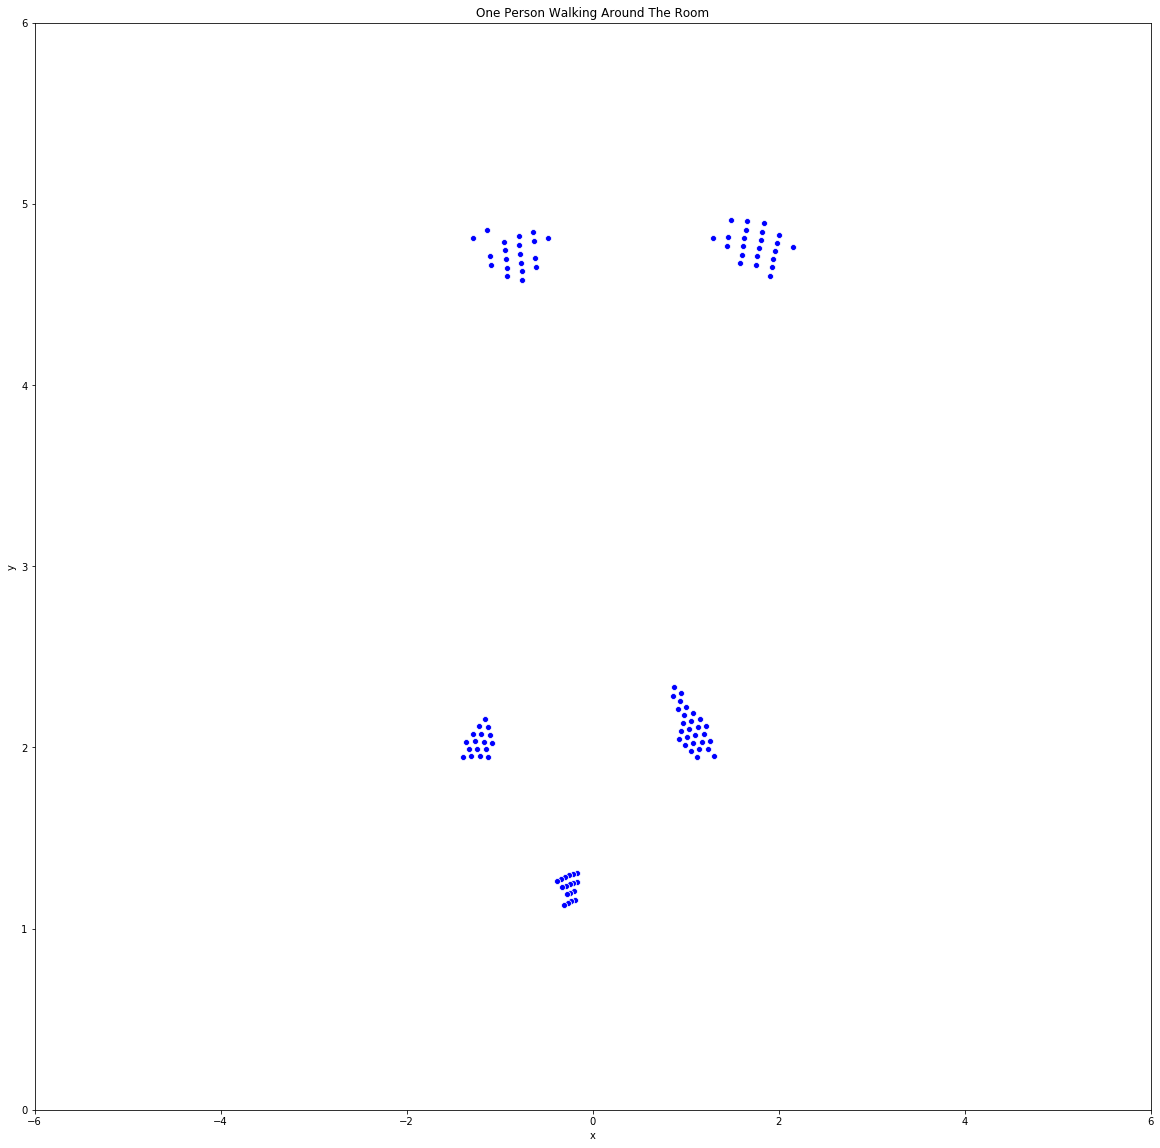

In [3]:
fig, (ax1) = plt.subplots(1)
fig.set_size_inches(20, 20)

parsingMatFile = 'C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Data\\Experiment 1\\fastWalk.mat'
tlvData = (loadmat(parsingMatFile))['tlvStream'][0]

#RKF 
centroidX =np.zeros((4,1))
centroidP = []
P = np.identity(4)
centroidP.extend([P])
Q = np.multiply(100,np.identity(4))
R = np.multiply(0.01,np.array([[1],[1]]))
#tree based
weightThresholdIntial = 0.2 #minimum distance between points
minClusterSizeInitial = 10
weightThresholdFinal = 0.8 #minimum distance between points
minClusterSizeFinal = 8 

#zone snr
snrFirstZone = 20
snrMiddleZone = 10
snrLastZone = 10

tlvHeaderLengthInBytes = 8
pointLengthInBytes = 16
targetLengthInBytes = 68

tiPosX = np.array([])
tiPosY = np.array([])

tiOutput = np.array([])
kalmanOutput = np.array([])
clusteringOutput = np.array([])
snrFilteredClusters = np.array([])
groundTruth = 0
xPositions = np.array([])

groundTruthDataCollection = False
locationDataNeeded = False
xGroup16 = np.array([])
yGroup16 = np.array([])
xLocationTI = np.array([])
yLocationTI = np.array([])

isFirst = 1

indexNo = [76,235,267,295,344]
for number in indexNo:
    for index in range(number,number+1):

        tlvStream = tlvData[index]

        #parsing
        pointCloud, targetDict = tlvParsing(tlvStream, tlvHeaderLengthInBytes, pointLengthInBytes, targetLengthInBytes)

        if pointCloud.size > 0:
            posX,posY,SNR = parsePointCloud(pointCloud) #dictionary that contains the point cloud data

            #initial noise reduction
            clusters = TreeClustering(posX, posY, SNR,weightThresholdIntial, minClusterSizeInitial)

            if clusters.size > 0:
    #             row 1 - x
    #             row 2 - y
    #             row 3 - SNR
    #             row 4 - cluster number

    #             snr zone snr test
    #             4.5 to the end -> last zone
    #             3-4.5m -> middle zone
    #             1-3m -> first zone
                snrMask_LastZone = np.logical_and(np.greater(clusters[1,:], 4.5), np.greater(clusters[2,:], snrLastZone)) #zone 4.5m and greater
                snrMask_MiddleZone = np.logical_and(np.logical_and(np.greater(clusters[1,:], 3), np.less_equal(clusters[1,:], 4.5)), 
                                                    np.greater(clusters[2,:], snrMiddleZone)) #zone 3-4.5m with SNR > 20
                snrMask_FirstZone = np.logical_and(np.less_equal(clusters[1,:], 3), np.greater(clusters[2,:], snrFirstZone))
                overallSnrMask = np.logical_or(np.logical_or(snrMask_FirstZone,snrMask_MiddleZone), snrMask_LastZone)

                snrFilteredClusters = clusters[:,overallSnrMask]

                if snrFilteredClusters.size > 0:
                    dbClusters = TreeClustering(snrFilteredClusters[0,:], snrFilteredClusters[1,:], 
                                                    snrFilteredClusters[2,:], 
                                                    weightThresholdFinal, minClusterSizeFinal)
                    if dbClusters.size > 0:
                        #row 1 - x
                        #row 2 - y
                        #row 3 - cluster number
                        k = int(max(dbClusters[3,:])) + 1 
                        points = np.transpose(np.array([dbClusters[0,:], dbClusters[1,:]]))

                        #kmeans 
                        centroidClusterer = KMeans(n_clusters= k).fit(points)
                        centroidData = np.array([centroidClusterer.cluster_centers_[:,0], centroidClusterer.cluster_centers_[:,1]])

                        #tracking
                        centroidX, centroidP,isFirst = LiveRKF(centroidData, centroidX, centroidP, Q, R, isFirst)
                        #calculate x and y positions
                        xPositions = np.multiply(centroidX[0,:], np.cos(centroidX[2,:]))
                        yPositions = np.multiply(centroidX[0,:], np.sin(centroidX[2,:]))
                        mask = np.logical_and((np.logical_and(xPositions<3,xPositions>-4)), np.logical_and(yPositions<5.5,yPositions>0.5))
                        xPositions = xPositions[mask]
                        yPositions= yPositions[mask]
                        #keep centroids that are inside the constraints 
                        centroidX = centroidX[:,mask]

                        #plot before/after snr reduction
                        snrDf = pd.DataFrame({'x':snrFilteredClusters[0,:],
                                             'y':snrFilteredClusters[1,:]})
                        preSNRDf = pd.DataFrame({'x':clusters[0,:],
                                             'y':clusters[1,:]})

    #                     prePlot = sns.scatterplot(x='x', y='y',data=preSNRDf,ax=ax1)
    #                     prePlot.set(xlim = (-6,6))
    #                     prePlot.set(ylim = (0,6))
    #                     prePlot.set_title('Before SNR Filtering')

                        snrPlot = sns.scatterplot(x='x', y='y',data=snrDf, ax=ax1, color='blue')
                        snrPlot.set(xlim = (-6,6))
                        snrPlot.set(ylim = (0,6))
                        snrPlot.set_title('One Person Walking Around The Room')
#                         sns.set(font_scale = 1)

                        #save figure
                        fig.savefig("C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Variable Density\\Walking.svg")


### Live Demo Timing Analysis

In [ ]:
#run on Rpi
#setup dataframe
#numberOfPeople, Iteration and Timing
timingData = np.array([])
for numberOfPeople in range(1,6):
    for iteration in range(1,1001):
        timing = #import from cProfile
        if timingData.size == 0:
            timingData = np.array([numberOfPeople,iteration,timing])
        else:
            timingData = np.vstack((timingData, np.array([numberOfPeople,iteration,timing])))

In [18]:
#save csv
timingDf = pd.DataFrame(timingData, columns=['Number Of People', 'Iteration', 'Runtime'])
timingDf.to_csv("C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Timing Analysis\\Timing Data.csv")

### Performance Gains (Tiny cluster exclusion)

In [2]:
### run on Rpi
#setup dataframe
#numberOfPeople, Iteration and Timing
timingData = np.array([])
for numberOfPeople in range(1,6):

    for iteration in range(1,1001):
        timingWith = #import from cProfile
        timingWithout = #import from cProfile
        if timingData.size == 0:
            timingData = np.array([numberOfPeople,iteration,timingWith, 'With Preliminary Noise Reduction'])
            timingData = np.vstack((timingData, np.array([numberOfPeople,iteration,timingWithout,'Without Preliminary Noise Reduction'])))
        else:
            timingData = np.vstack((timingData,np.array([numberOfPeople,iteration,timingWith, 'With Preliminary Noise Reduction'])))
            timingData = np.vstack((timingData, np.array([numberOfPeople,iteration,timingWithout,'Without Preliminary Noise Reduction'])))

SyntaxError: invalid syntax (<ipython-input-2-5bcc35bcfe84>, line 8)

In [27]:
#save csv
timingDf = pd.DataFrame(timingData, columns=['Number Of People', 'Iteration', 'Runtime', 'With/Without'])
timingDf.to_csv("C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Results\\Timing Analysis\\NoiseRemovalPerformanceGains.csv")

## Variable Density Clusters